http://actionrecognition.net/files/dsetdetail.php?did=15;
https://github.com/epic-kitchens/annotations

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from childes_mi.utils.paths import DATA_DIR, ensure_dir, EPIC_KITCHENS_DIR
import urllib.request

In [3]:
import pandas as pd

In [4]:
actions_data = pd.read_csv(EPIC_KITCHENS_DIR / 'EPIC_train_action_labels.csv')

In [5]:
from tqdm.autonotebook import tqdm

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [6]:
actions = [actions_data[actions_data.video_id == vid].verb_class.values for vid in tqdm(actions_data.video_id.unique())]

In [7]:
actions_name = [[actions_data[actions_data.video_id == vid].verb.values, actions_data[actions_data.video_id == vid].noun.values] for vid in tqdm(actions_data.video_id.unique())]

In [8]:
behav_lens = [len(i) for i in actions]

In [9]:
import matplotlib.pyplot as plt

In [10]:
import numpy as np

In [11]:
np.sum(behav_lens)

28472

In [12]:
len(np.unique(np.concatenate(actions)))

119

In [13]:
np.median(behav_lens)

45.0

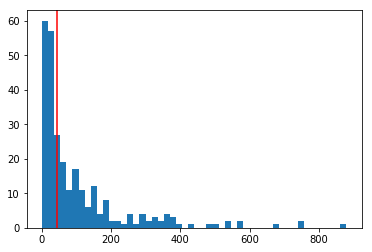

In [14]:
fig, ax = plt.subplots()
ax.hist(behav_lens, bins = 50);
ax.axvline(np.median(behav_lens), color='red')

### MI

In [15]:
from childes_mi.information_theory import mutual_information as mi

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.cluster.supervised module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics.cluster. Anything that cannot be imported from sklearn.metrics.cluster is now part of the private API.
  warnings.warn(message, FutureWarning)
/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.cluster.expected_mutual_info_fast module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics.cluster. Anything that cannot be imported from sklearn.metrics.cluster is now part of the private API.
  warnings.warn(message, FutureWarning)


In [16]:
distances = np.arange(1,250).astype('int')

In [17]:
actions_indv = [["{}_{}".format(bi, element) for element in bout] for bi, bout in enumerate(tqdm(actions))]

In [18]:
actions_indv[0][:10]

['0_2', '0_12', '0_3', '0_2', '0_0', '0_0', '0_0', '0_3', '0_2', '0_0']

In [19]:
(MI, MI_var), (shuff_MI, shuff_MI_var) = mi.sequential_mutual_information(
    np.array([np.random.permutation(i) for i in actions_indv]), distances=distances, n_jobs=-1, estimate=True
)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:    4.2s


[Parallel(n_jobs=-1)]: Done 236 out of 249 | elapsed:    5.3s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done 249 out of 249 | elapsed:    5.4s finished


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.1s


[Parallel(n_jobs=-1)]: Done  36 out of 249 | elapsed:    0.4s remaining:    2.4s
[Parallel(n_jobs=-1)]: Done 136 out of 249 | elapsed:    0.9s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done 249 out of 249 | elapsed:    1.0s finished


In [20]:
MI_DF = pd.DataFrame(
    [[MI, MI_var, shuff_MI, shuff_MI_var, distances]],
    columns=["MI", "MI_var", "shuff_MI", "shuff_MI_var", "distances"],
)

In [21]:
MI_DF.to_pickle(DATA_DIR / "mi" / "epic_kitchens_shuffled.pickle")

In [22]:
row = MI_DF.iloc[0]

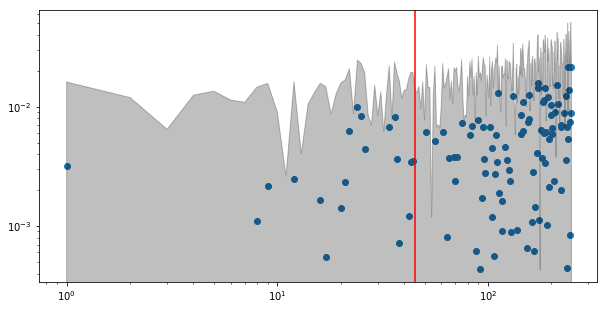

In [23]:
fig, ax = plt.subplots(figsize=(10,5))
MI = row.MI-row.shuff_MI
MI_var = row.MI_var
ax.axvline(np.median(behav_lens), color='red')
ax.scatter(distances, MI)
ax.fill_between(distances, MI-MI_var, MI+MI_var, alpha = 0.25, color= 'k')
#ax.set_ylim([1e-3, 1])
ax.set_yscale('log')
ax.set_xscale('log')

In [24]:
from matplotlib import gridspec

In [25]:
median_len = 45

In [26]:
from childes_mi.utils.paths import DATA_DIR, FIGURE_DIR
from childes_mi.utils.general import flatten,save_fig

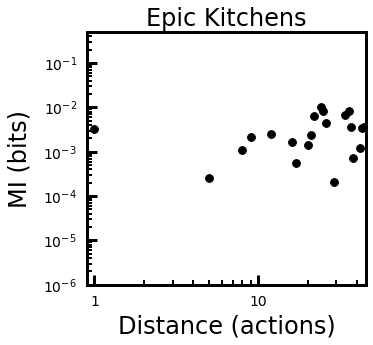

In [35]:
yoff=-.20
ncols = 4
zoom = 5
hr = [1, 0.5, 0.5, 0.5]
nrows = np.ceil(len(MI_DF)/ncols).astype(int)
fig = plt.figure(figsize=(len(MI_DF)*zoom*1.0,np.sum(hr)*zoom)) 
gs = gridspec.GridSpec(ncols=len(MI_DF), nrows=4, height_ratios=hr) 

axi = 0
row = MI_DF.iloc[0]

color = 'k'#LCOL_DICT[row.language]
ax0 = plt.subplot(gs[0,axi])
ax = ax0
sig = np.array(row.MI-row.shuff_MI)
distances = row.distances
sig = sig
# get signal limits
sig_lims = np.log([np.min(sig[sig>0]), np.nanmax(sig)])
sig_lims = [sig_lims[0] - (sig_lims[1]-sig_lims[0])/10,
                sig_lims[1] + (sig_lims[1]-sig_lims[0])/10]

if axi==0: 
        ax.set_ylabel('MI (bits)', labelpad=5, fontsize=24)
        ax.yaxis.set_label_coords(yoff,0.5)

# plot real data
ax.scatter(distances, sig, alpha = 1, s=60, color=color)   

ax.set_xlabel('Distance (actions)', labelpad=5, fontsize=24)
#print(row.language, distances[peak_of_interest])

for ax in [ax0]:
    ax.set_xlim([distances[0], distances[-1]])
    sig_lims[0] = np.log(10e-6)
    ax.set_ylim([1e-6, 0.5])
    ax.tick_params(which='both', direction='in', labelsize=14, pad=10)
    ax.tick_params(which='major', length=10, width =3)
    ax.tick_params(which='minor', length=5, width =2)
    ax.set_xscale( "log" , basex=10)
    ax.set_yscale( "log" , basey=10)
    ax.set_xticks([])
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(3)
        ax.spines[axis].set_color('k')

ax.set_xticks([1,10])
ax.set_xticklabels(['1','10'])
ax.set_xlim([0.9, 45.5])
if axi !=0:
    for ax in [ax0,ax1,ax2]:
        ax.yaxis.set_ticklabels([])

gs.update(wspace=0.075, hspace=0.1)
ax0.set_title("Epic Kitchens", fontsize=24)
save_fig(FIGURE_DIR/'epic_kitchens-1000-shuffled')